> This notebook is intended to be used in Google Colab

## Imports

In [909]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Helper functions


In [910]:
def label_to_index(label):
    if 'A' <= label <= 'Z':
        return ord(label) - ord('A')
    elif '0' <= label <= '9':
        return ord(label) - ord('0') + 26
    else:
        raise ValueError(f"Unsupported label: {label}")

In [911]:
def index_to_label(index):
    if 0 <= index < 26:
        return chr(index + ord("A"))
    elif 26 <= index < 36:
        return chr(index - 26 + ord("0"))
    else:
        raise ValueError(f"Unsupported class index: {index}")

In [912]:
def show(img):
  plt.imshow(img[:,:,0], cmap='gray', interpolation='none')

## Loading Data

In [913]:
directory = 'letters/'

# Parameters
img_height, img_width = 32, 32
batch_size = 32
epochs = 10
num_augmented_images = 800

images = []
labels = []

for filename in os.listdir(directory):
    if filename.endswith('.png'):
        img_path = os.path.join(directory, filename)
        label = filename.split('.')[0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        img = cv2.resize(img, (img_width, img_height))
        images.append(img)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels_text = labels
labels = np.array(labels)


images = np.expand_dims(images, axis=-1)


B
(32, 32, 1)


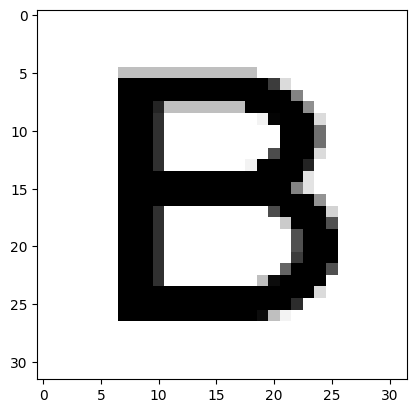

In [914]:
print(labels[0])
print(images[0].shape)
show(images[0])

## Data Augmentation

In [915]:
labels = tf.keras.utils.to_categorical([label_to_index(label) for label in labels], num_classes=36)

def custom_preprocessing(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    dilated_image = cv2.erode(image, kernel, iterations=1)
    img_array = dilated_image.reshape(dilated_image.shape + (1,))
    return img_array

datagen = ImageDataGenerator(
    rotation_range=6,
    width_shift_range=0.12, # up-down
    height_shift_range=0.12, # left-right
    shear_range=0.35,
    zoom_range=0.35,
    horizontal_flip=False,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing
)

augmented_images = []
augmented_labels = []

for i, image in enumerate(images):
    img_array = image.reshape((1,) + image.shape)
    label = labels[i]

    j = 0
    for batch in datagen.flow(img_array, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        j += 1
        if j >= num_augmented_images:
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

augmented_images = augmented_images / 255.0

# 80% train, 10% validate, 10% test
x_train, x_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

In [916]:
x_train.shape, x_val.shape, x_test.shape

((22400, 32, 32, 1), (2800, 32, 32, 1), (2800, 32, 32, 1))

In [917]:
labels[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [918]:
import random

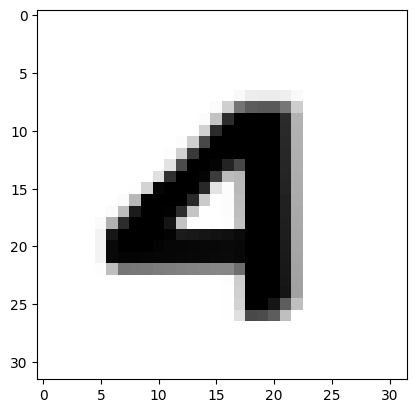

In [919]:
show(x_train[random.randint(0, 150)])

## Model

In [920]:
model = Sequential([
    # slightly modified lenet
    Conv2D(16, (5, 5), activation='relu', input_shape=(img_height, img_width, 1)),
    AveragePooling2D(pool_size=(2, 2), strides=2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(36, activation='sigmoid')
])

In [921]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.0008,
    restore_best_weights=True
)

model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
700/700 [==============================] - 23s 29ms/step - loss: 0.0771 - accuracy: 0.4986 - val_loss: 0.0130 - val_accuracy: 0.9532
Epoch 2/10
700/700 [==============================] - 19s 27ms/step - loss: 0.0159 - accuracy: 0.9198 - val_loss: 0.0049 - val_accuracy: 0.9814
Epoch 3/10
700/700 [==============================] - 18s 26ms/step - loss: 0.0092 - accuracy: 0.9581 - val_loss: 0.0029 - val_accuracy: 0.9879
Epoch 4/10
700/700 [==============================] - 18s 26ms/step - loss: 0.0064 - accuracy: 0.9709 - val_loss: 0.0024 - val_accuracy: 0.9893
Epoch 5/10
700/700 [==============================] - 19s 27ms/step - loss: 0.0053 - accuracy: 0.9764 - val_loss: 0.0019 - val_accuracy: 0.9900
Epoch 6/10
700/700 [==============================] - 18s 26ms/step - loss: 0.0041 - accuracy: 0.9829 - val_loss: 0.0017 - val_accuracy: 0.9939
Epoch 7/10
700/700 [==============================] - 18s 26ms/step - loss: 0.0036 - accuracy: 0.9848 - val_loss: 0.0010 - val_accuracy:

In [922]:
# notify that training is finished (optional)
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [923]:
model.save('ocr.keras')

## (Debug) visualise what CNN sees

In [924]:
def visualize2(model, layer, img, r, c):
  from keras import Model
  # expand dimensions so that it represents a single 'sample'
  img = np.expand_dims(img, axis=0)
  outputs = [layer.output]
  model = Model(inputs=model.inputs, outputs=outputs)
  # get feature map for first hidden layer
  feature_maps = model.predict(img)
  for fmap in feature_maps:
  # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(r):
      for _ in range(c):
        # specify subplot and turn of axis
        ax = plt.subplot(r, c, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(fmap[:, :, ix-1], cmap='gray')
        ix += 1

In [925]:
# plt.figure()
# img = x_test[41] # A
# show(img)
# plt.figure()
# visualize2(model, model.layers[0], img, 2, 2)
# plt.figure()
# visualize2(model, model.layers[1], img, 2, 2)
# plt.figure()
# visualize2(model, model.layers[2], img, 4, 4)
# plt.figure()
# visualize2(model, model.layers[3], img, 4, 4)
# # plt.figure()
# # visualize2(model, model.layers[4], img, 4, 8)

## Validate the model

I


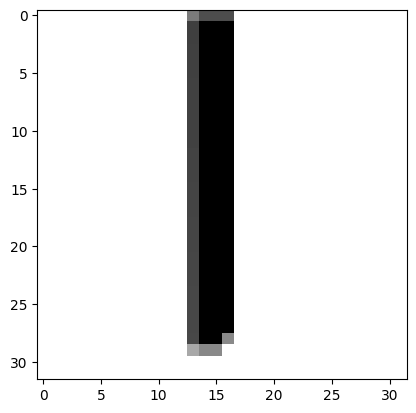

In [926]:
# Test on random character
img_to_pred = x_test[random.randint(0, 150)]
img = np.expand_dims(img_to_pred, axis=0)
predictions = model.predict(img, verbose=0)
predicted_class_index = np.argmax(predictions)
predicted_label = index_to_label(predicted_class_index)
print(predicted_label)
show(img_to_pred)

In [927]:
import itertools

In [928]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [929]:
from sklearn.metrics import confusion_matrix

In [930]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

88/88 [==============================] - 1s 11ms/step - loss: 0.0011 - accuracy: 0.9957
Test score: 0.0011003048857674003
Test accuracy: 0.9957143068313599


In [931]:
predict = model.predict(x_test)
predicted_classes = np.argmax(predict,axis=1)

88/88 [==============================] - 1s 8ms/step


Confusion matrix, without normalization
[[77  0  0 ...  0  0  0]
 [ 0 82  0 ...  0  0  0]
 [ 0  0 71 ...  0  0  0]
 ...
 [ 0  0  0 ... 70  0  0]
 [ 0  0  0 ...  0 84  0]
 [ 0  0  0 ...  0  0 69]]


<Figure size 640x480 with 0 Axes>

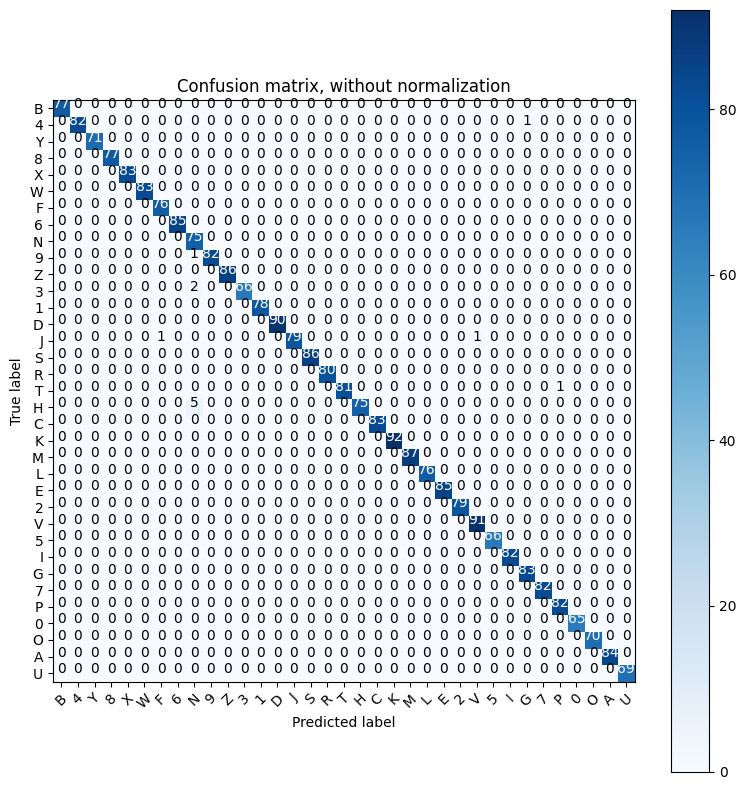

In [932]:
yt = np.argmax(y_test, axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == yt)[0]
incorrect_indices = np.nonzero(predicted_classes != yt)[0]
cnf_matrix = confusion_matrix(yt, predicted_classes)

class_names = labels_text

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## (Optional) Validate on real data

In [933]:
expected = "W0104E"
got = ""
for i in range(6):
        img = np.load(f'letters_cut/{i}.npy')
        resized_image = cv2.resize(img, (img_width, img_height))
        img = np.expand_dims(resized_image, axis=0)
        predictions = model.predict(img, verbose=0)
        predicted_class_index = np.argmax(predictions)
        predicted_label = index_to_label(predicted_class_index)
        got += predicted_label
print(expected)
print(got)

W0104E
WOTO4E


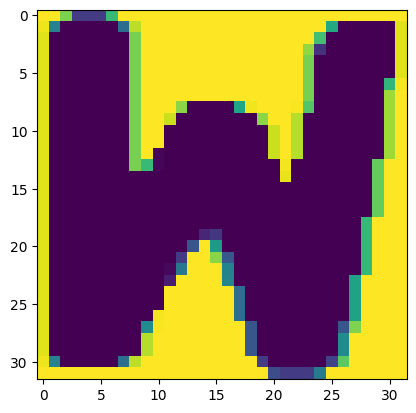

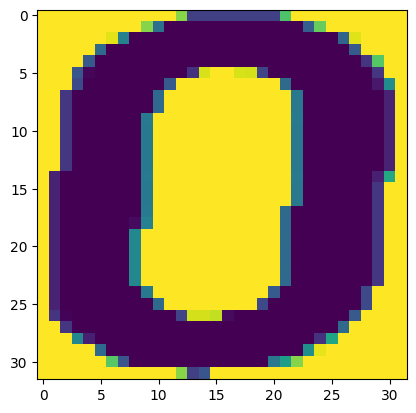

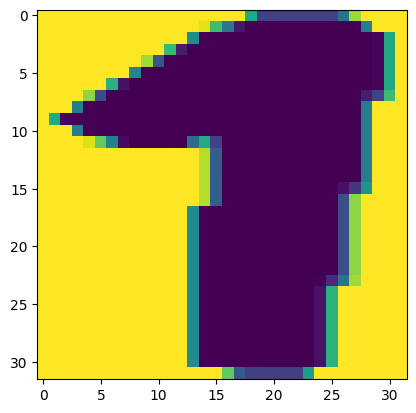

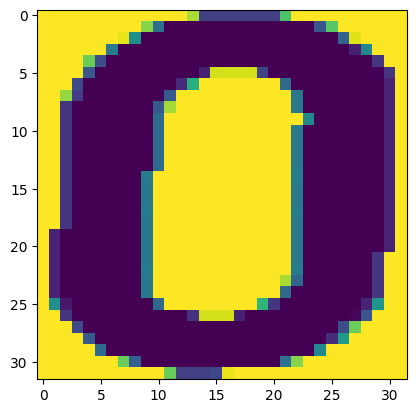

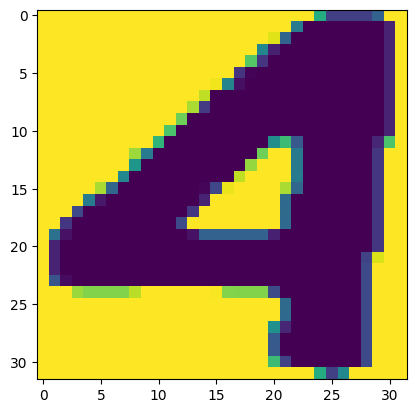

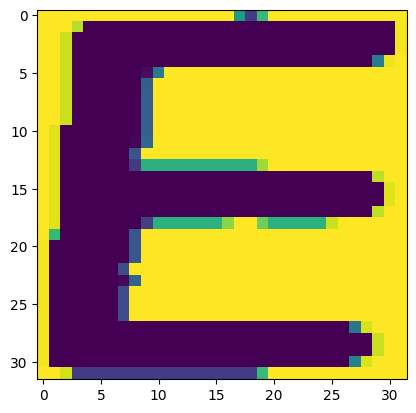

In [934]:
for i in range(6):
        img = np.load(f'letters_cut/{i}.npy')
        plt.figure()
        resized_image = cv2.resize(img, (img_width, img_height))
        plt.imshow(resized_image)